# Part 2 : Building the modular network

### Overview

This Notebook continues where Part 2 left. We work with the original paper once again, but this rebuilding the modular network.

This Notebook builds the network in a more efficient way.

### Chapters


### 0. Plot configuration


In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

%load_ext autoreload
%autoreload 2

plt.style.use(["science"])
plt.rcParams["figure.figsize"] = (12, 7)


## 1. Building the network


In [2]:
import nest
import nest.raster_plot
import pylab

nest.ResetKernel()
n = 4  # number of threads'
dt = 0.1

nest.SetKernelStatus(
    {"local_num_threads": n, "resolution": dt, "overwrite_files": True}
)

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.4
 Built: Mar  7 2023 05:58:34

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Apr 04 18:32:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


### 1a. Model parameters


In [3]:
N_total = 10_000
n_submodules = 16

E_perc = 4 / 5
N_E = int(N_total * E_perc)  # Number of excitatory neurons
N_I = int(N_total * (1 - E_perc))  # Number of excitatory neurons

In [4]:
neuron_model = "iaf_cond_exp"

neuron_params = {
    "V_m": -60.0,
    "E_L": -60.0,
    "V_th": -50.0,
    "V_reset": -60.0,
    "t_ref": 5.0,
    "E_ex": 0.0,
    "E_in": -80.0,
    "C_m": 100.0,
    "g_L": 10.0,
    # "I_e": 50.0,
    "tau_syn_ex": 5.0,
    "tau_syn_in": 10.0,
}

# Synapse parameters
P_0 = 0.01  # Connection probability
delay = 1.0

J_E = 0.2
J_I = -0.8

# Rewiring parameters
R_ex = 0.99
R_inh = 1

In [5]:
nest.CopyModel(
    "static_synapse",
    "excitatory_synapse",
    {
        "weight": J_E,
        "delay": delay,
    },
)

nest.CopyModel(
    "static_synapse",
    "inhibitory_synapse",
    {
        "weight": J_I,
        "delay": delay,
    },
)

### 1b. Building the modular network


What we now want to do is to take the same number of _total_ neurons as before, but change their topology by rewiring connections. Something like the follow figure:

<img src="./../img/neural_columns.png" width="600">

The paper uses a recursive method for splitting the random network into submodules, where

- inhibitory synapses are always rewired within the module
- excitatory synapses are rewired within with the probability $R_{ex}$,

The paper also provides a formula for computing inter-modular connection probabilities:

Splitting a module into $m$ submodules of equal size at each level, the connection density between the modules of the $i$ th level is:

<img src="https://www.frontiersin.org/files/Articles/2252/fncom-05-00030-HTML/image_n/fncom-05-00030-e006.gif" width="500">

where $i = 1,…,l$, if a network is rewiring into a l-level HMN. The connection density within each unit of the network, that is, the l-level module, is

<img src="https://www.frontiersin.org/files/Articles/2252/fncom-05-00030-HTML/image_n/fncom-05-00030-e007.gif" width="500">


**Generate nodes**


In [6]:
def generate_base_network(nodes, n_modules, E_perc):
    n_of_nodes = len(nodes)
    len_submodule = int(n_of_nodes // n_modules)
    print(
        f"Generating submodules of size {len_submodule}, total network size {n_of_nodes}"
    )

    submodule_dict = {}
    for submodule_idx, node_idx in enumerate(range(0, n_of_nodes, len_submodule)):
        submodule = nodes[node_idx : node_idx + len_submodule]
        submodule_dict[submodule_idx + 1] = submodule

    print("Base network configured")

    return submodule_dict

In [7]:
nodes = nest.Create(neuron_model, N_total, params=neuron_params)
submodule_dict = generate_base_network(nodes, n_submodules, E_perc=0.8)

Generating submodules of size 625, total network size 10000
Base network configured


**Connect the nodes**


- Get raw connection probabilities from the paper


In [8]:
def get_local_connection_density(P_0, R_ex, neuron_type):
    if neuron_type == "excitatory":
        return (0.8 * P_0) * (1 + R_ex) ** 4
    elif neuron_type == "inhibitory":
        return 0.2 * P_0 * 2**4
    else:
        raise (f"{neuron_type} is not a valid neuron")


def get_inter_connection_density_by_level(P_0, R_ex, l):
    return (0.8 * P_0) * (1 + R_ex) ** (l - 1) * (1 - R_ex)

- Get connection probability from a source_id and target_id


In [9]:
import numpy as np


def find_smallest_common_interval(source_id, target_id, interval):
    half_idx = int(len(interval) / 2)
    first_half = interval[:half_idx]
    second_half = interval[half_idx:]
    smallest_common_interval = interval

    for sub_interval in [first_half, second_half]:
        if source_id in sub_interval and target_id in sub_interval:
            if len(sub_interval) == 1:
                return sub_interval
            # Nodes exists in a smaller module
            smallest_common_interval = find_smallest_common_interval(
                source_id=source_id,
                target_id=target_id,
                interval=sub_interval,
            )

    return smallest_common_interval


def get_inter_connection_density(source_id, target_id, n_submodules, P_0, R_ex):
    """Computes the level where the nodes closest common parent lives."""
    submodules_ids = list(range(1, n_submodules + 1))
    smallest_common_interval = find_smallest_common_interval(
        source_id, target_id, submodules_ids
    )
    level = np.log2(n_submodules / len(smallest_common_interval))
    connection_density = get_inter_connection_density_by_level(P_0, R_ex, l=level)
    return connection_density

- Hook up the network


In [10]:
def connect_nodes(
    source_nodes, target_nodes, exc_connection_density, inh_connection_density, E_perc
):
    N_E = int(len(source_nodes) * E_perc)
    source_nodes_E = source_nodes[:N_E]
    source_nodes_I = source_nodes[N_E:]

    if exc_connection_density > 0:
        exc_conn_dict = {"rule": "pairwise_bernoulli", "p": exc_connection_density}
        nest.Connect(
            source_nodes,
            target_nodes,
            syn_spec={"synapse_model": "excitatory_synapse"},
            conn_spec=exc_conn_dict,
        )
    if inh_connection_density > 0:
        inh_conn_dict = {"rule": "pairwise_bernoulli", "p": inh_connection_density}
        nest.Connect(
            source_nodes,
            target_nodes,
            syn_spec={"synapse_model": "inhibitory_synapse"},
            conn_spec=inh_conn_dict,
        )


def connect_submodules(submodule_dict, P_0, R_ex, E_perc):
    n_submodules = len(submodule_dict)

    for source_idx, source_nodes in submodule_dict.items():
        print(f"Connecting source: {source_idx}...")
        for target_idx, target_nodes in submodule_dict.items():
            exc_connection_density = 0
            inh_connection_density = 0
            if target_idx == source_idx:
                exc_connection_density = get_local_connection_density(
                    P_0=P_0, R_ex=R_ex, neuron_type="excitatory"
                )
                inh_connection_density = get_local_connection_density(
                    P_0=P_0, R_ex=R_ex, neuron_type="inhibitory"
                )
            else:
                exc_connection_density = get_inter_connection_density(
                    source_id=source_idx,
                    target_id=target_idx,
                    n_submodules=n_submodules,
                    P_0=P_0,
                    R_ex=R_ex,
                )

            connect_nodes(
                source_nodes=source_nodes,
                target_nodes=target_nodes,
                exc_connection_density=exc_connection_density,
                inh_connection_density=inh_connection_density,
                E_perc=E_perc,
            )

            print(
                f"- Connected to target: {target_idx}, exc_dens: {exc_connection_density}, inh_dens: {inh_connection_density}"
            )


connect_submodules(submodule_dict, P_0, R_ex, E_perc)

Connecting source: 1...
- Connected to target: 1, exc_dens: 0.12545913608, inh_dens: 0.032
- Connected to target: 2, exc_dens: 0.0003168080000000003, inh_dens: 0
- Connected to target: 3, exc_dens: 0.00015920000000000013, inh_dens: 0
- Connected to target: 4, exc_dens: 0.00015920000000000013, inh_dens: 0
- Connected to target: 5, exc_dens: 8.000000000000007e-05, inh_dens: 0
- Connected to target: 6, exc_dens: 8.000000000000007e-05, inh_dens: 0
- Connected to target: 7, exc_dens: 8.000000000000007e-05, inh_dens: 0
- Connected to target: 8, exc_dens: 8.000000000000007e-05, inh_dens: 0
- Connected to target: 9, exc_dens: 4.020100502512566e-05, inh_dens: 0
- Connected to target: 10, exc_dens: 4.020100502512566e-05, inh_dens: 0
- Connected to target: 11, exc_dens: 4.020100502512566e-05, inh_dens: 0
- Connected to target: 12, exc_dens: 4.020100502512566e-05, inh_dens: 0
- Connected to target: 13, exc_dens: 4.020100502512566e-05, inh_dens: 0
- Connected to target: 14, exc_dens: 4.020100502512

**Verifying the result**

The connections should look like the following connection density matrix:

<img src="https://www.frontiersin.org/files/Articles/2252/fncom-05-00030-HTML/image_m/fncom-05-00030-g001.jpg" width="300">


<Axes: >

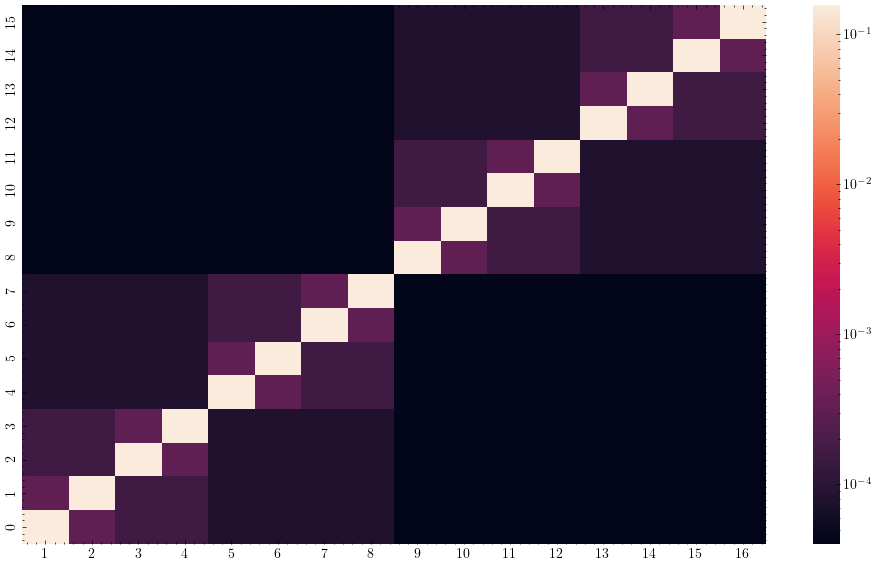

In [11]:
import seaborn as sns
from matplotlib.colors import LogNorm
import pandas as pd


def generate_connection_density():
    connection_density = {idx: [] for idx in range(1, n_submodules + 1)}
    for source_idx, source_nodes in submodule_dict.items():
        for target_idx, target_nodes in submodule_dict.items():
            exc_connection_density = 0
            inh_connection_density = 0
            if target_idx == source_idx:
                exc_connection_density = get_local_connection_density(
                    P_0=P_0, R_ex=R_ex, neuron_type="excitatory"
                )
                inh_connection_density = get_local_connection_density(
                    P_0=P_0, R_ex=R_ex, neuron_type="inhibitory"
                )
            else:
                exc_connection_density = get_inter_connection_density(
                    source_id=source_idx,
                    target_id=target_idx,
                    n_submodules=n_submodules,
                    P_0=P_0,
                    R_ex=R_ex,
                )

            connection_density[source_idx] += [
                inh_connection_density + exc_connection_density
            ]

    return pd.DataFrame(connection_density).iloc[::-1]


connection_density = generate_connection_density()
sns.heatmap(connection_density, norm=LogNorm(), cmap="rocket")

### 2. Simulate the network


Providing each node with background noise activation for 200 ms, and then removing the noise to check whether the networks could sustain the activity on their own.


In [12]:
noise = nest.Create(
    "poisson_generator",
    1,
    {
        "rate": 20_000,
        "start": 0,
        "stop": 200,
    },
)
nest.Connect(noise, nodes)


spikes = nest.Create("spike_recorder", 1, [{"label": "va-py-ex"}])
spikes_E = spikes[:1]
nest.Connect(nodes, spikes_E)

In [13]:
""" simtime = 1000  # ms
nest.Simulate(simtime) """

' simtime = 1000  # ms\nnest.Simulate(simtime) '

In [14]:
""" nest.raster_plot.from_device(spikes_E, hist=True) """

' nest.raster_plot.from_device(spikes_E, hist=True) '

## 3. Replicate paper results


### 3.2 Variation of Firing Patterns


Let's now explore this parameter space of synaptic weights, notice that our parameters are x10 the values on the graph:

<img src="https://www.frontiersin.org/files/Articles/2252/fncom-05-00030-HTML/image_m/fncom-05-00030-g002.jpg" width="600">


**The IS zone**

As the raster plot shows, although the Poisson nose only runs between 0 - 200 ms, the network activity persists until the end of the simulation - 1000ms. Indicating that we have found the delicate balance of E / I strength


Generating submodules of size 625, total network size 10000
Apr 04 18:32:30 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Base network configured
Network fully built.

Apr 04 18:32:31 NodeManager::prepare_nodes [Info]: 
    Preparing 10008 nodes for simulation.

Apr 04 18:32:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10008
    Simulation time (ms): 2500
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Apr 04 18:32:45 SimulationManager::run [Info]: 
    Simulation finished.


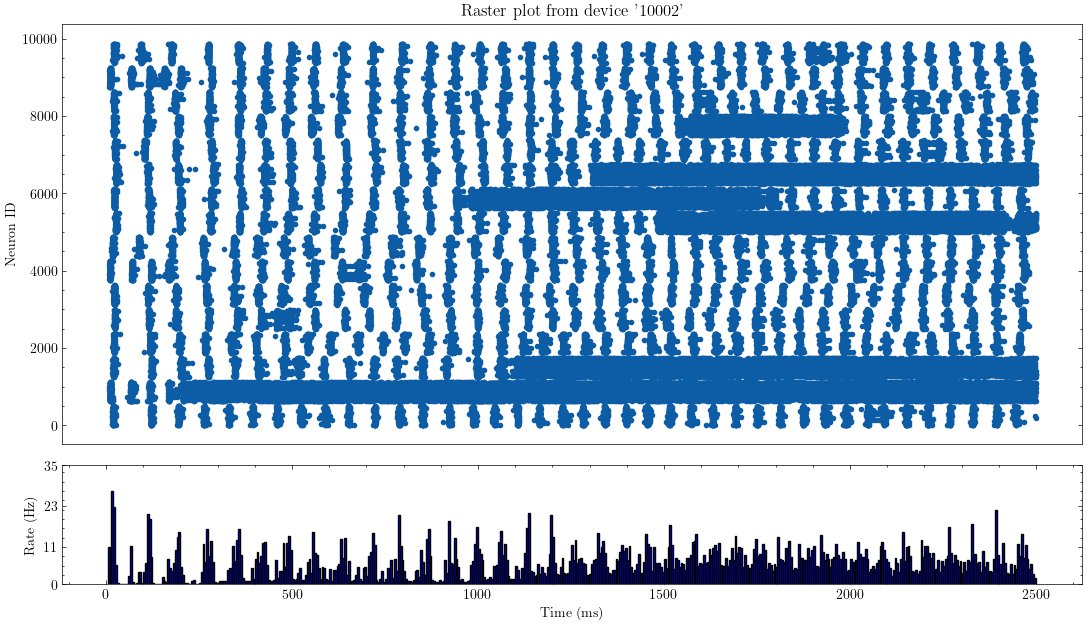

In [15]:
from classes.hmn_network import HMN_network

nest.ResetKernel()

params_1 = {
    "J_E": 0.5 * 10,
    "J_I": -8.4 * 10,
    "verbose": False,
}
simtime = 2500

hmm_network_1 = HMN_network(**params_1)
hmm_network_1.build()
hmm_network_1.simulate(
    simtime=simtime,
    noise_hz=400,
    stimulate_module_ids=[2, 7, 15],
    record_module_ids=list(range(1, 17)),
)
hmm_network_1.plot()

**The IT zone**

As the raster plot shows, the network activity dies when the Poisson generator stops.


Generating submodules of size 625, total network size 10000
Base network configured

Apr 04 18:32:46 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Network fully built.

Apr 04 18:32:47 NodeManager::prepare_nodes [Info]: 
    Preparing 10008 nodes for simulation.

Apr 04 18:32:47 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10008
    Simulation time (ms): 2000
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Apr 04 18:32:57 SimulationManager::run [Info]: 
    Simulation finished.


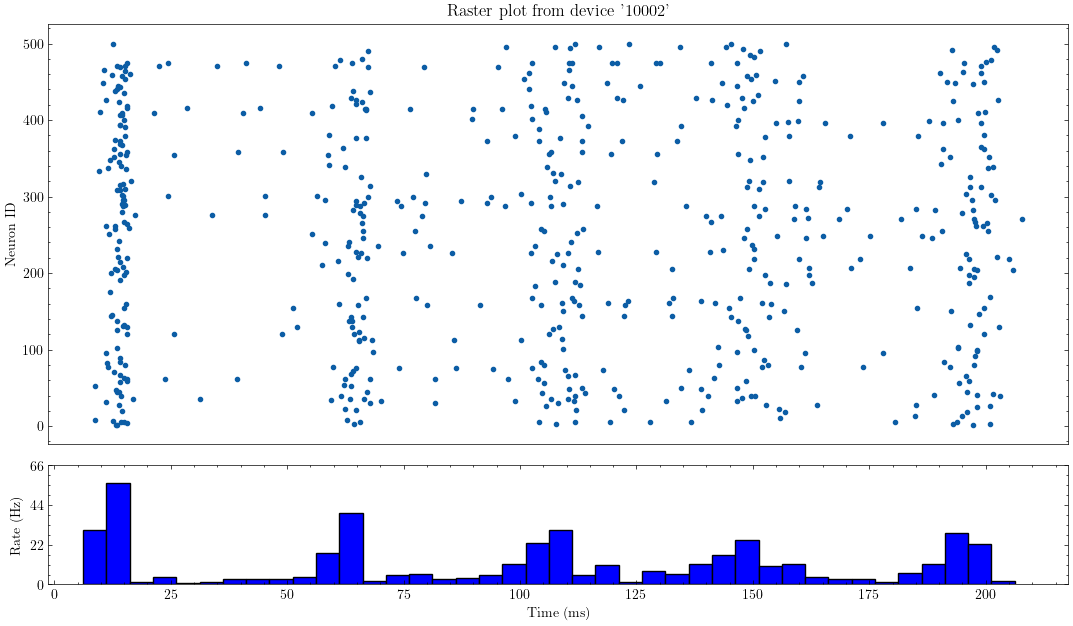

In [16]:
from classes.hmn_network import HMN_network

nest.ResetKernel()

params_2 = {
    "J_E": 0.1 * 10,
    "J_I": -8.0 * 10,
    "verbose": False,
}
simtime = 2000

hmm_network_2 = HMN_network(**params_2)
hmm_network_2.build()
hmm_network_2.simulate(
    simtime=simtime,
    noise_hz=400,
    stimulate_module_ids=[
        1,
    ],
    record_module_ids=list(range(1, 17)),
)
hmm_network_2.plot()

### 3.3 Critical Behavior in HMNs


The paper investigated whether the activity of the networks has properties of criticality.

They analyzed the

- distribution of the size of each activity of a module, and
- the length ls of the silent interval between two active periods (Figure 2B).

Activity size is measured as the number of spikes fired in an active period.


Generating submodules of size 625, total network size 10000
Base network configured

Apr 04 18:34:05 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Network fully built.

Apr 04 18:34:06 NodeManager::prepare_nodes [Info]: 
    Preparing 10008 nodes for simulation.

Apr 04 18:34:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10008
    Simulation time (ms): 6000
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Apr 04 18:34:38 SimulationManager::run [Info]: 
    Simulation finished.


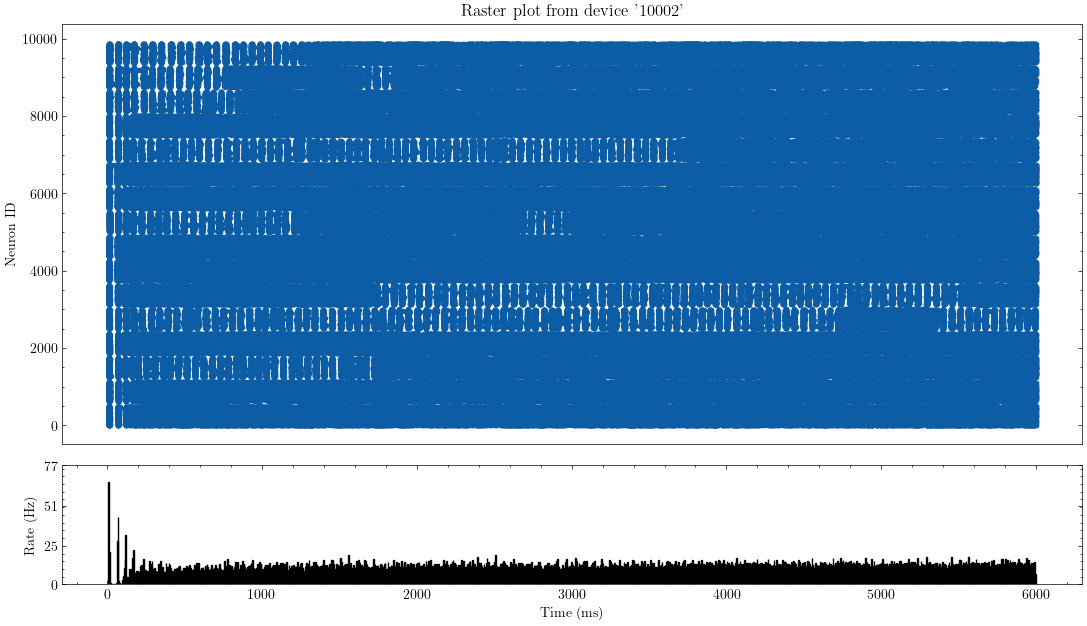

In [19]:
from classes.hmn_network import HMN_network


params_3 = {
    "J_E": 0.5 * 10,
    "J_I": -8.0 * 10,
    "verbose": False,
}
simtime = 6_000

hmm_network_3 = HMN_network(**params_3)
hmm_network_3.build()
hmm_network_3.simulate(
    simtime=simtime,
    noise_hz=400,
    stimulate_module_ids=list(range(1, 17)),
    record_module_ids=list(range(1, 17)),
)
hmm_network_3.plot()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

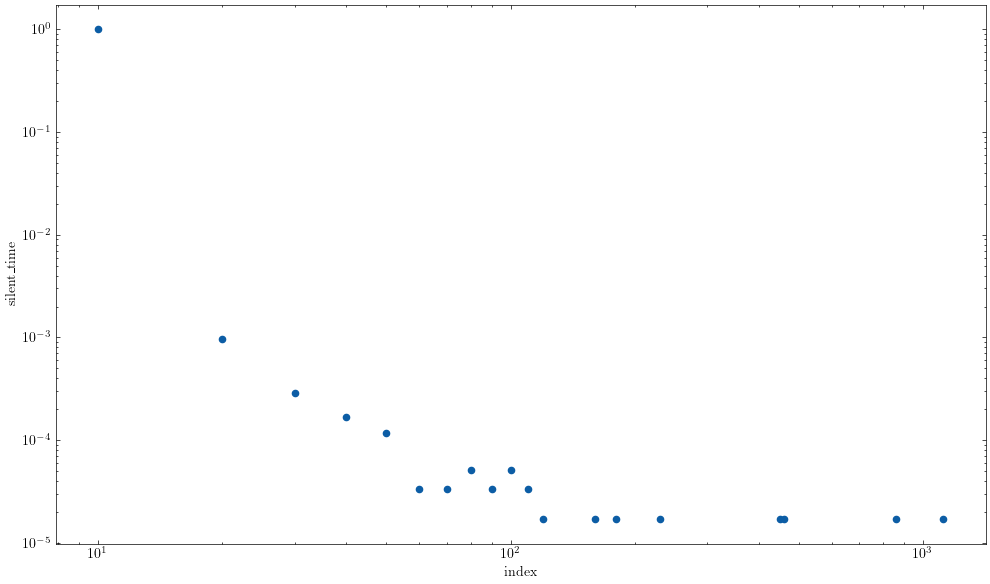

In [20]:
import pandas as pd
from scipy.optimize import curve_fit


def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c


def fit_avalanches_to_power_distribution(spike_events):
    df_silent_time = get_silent_time_distribution(spike_events)

    X = df_silent_time.index
    y = df_silent_time["silent_time"]

    popt, pcov = curve_fit(func_powerlaw, X, y)
    popt = np.round(popt, 2)

    print("Function: c0 + x**m * c")
    print(f"Curve fit: c0={popt[0]}, m={popt[1]}, c={popt[2]}")


def get_silent_time_distribution(spike_events):
    df_spike_events = (
        pd.DataFrame(spike_events).sort_values("times").reset_index(drop=True)
    )
    df_spike_events["times"] = df_spike_events["times"] * 100

    df_silent_time = (
        df_spike_events.assign(
            silent_time=df_spike_events["times"]
            - df_spike_events["times"].shift(periods=1)
        )
        .query("silent_time > 0.1")
        .silent_time.round(3)
        .value_counts()
        .to_frame()
    )
    return df_silent_time.divide(df_silent_time.sum())


def plot_silent_period_distribution(spike_events):
    df_silent_time = get_silent_time_distribution(spike_events)

    df_silent_time.reset_index().plot(
        logx=True, logy=True, kind="scatter", x="index", y="silent_time"
    )


spikes_E = hmm_network_3.spikes_E
spike_events = spikes_E.get("events")

plot_silent_period_distribution(spike_events)
fit_avalanches_to_power_distribution(spike_events)

### 3.6 Emergence of a Low-Frequency Component in Network Activity


It fits the average potential. I think I need to wire in a multimeter

In [ ]:
import numpy as np
import scipy.signal


def plot_power_spectrum_density(spike_events, sampling_frequency):
    # 1. PRE PROCESSING
    df_spike_events = pd.DataFrame(spike_events)
    df_spike_events["times"] = df_spike_events["times"].round(4)
    df_spike_events = df_spike_events.groupby("times").sum()

    empty_sampling_df = pd.DataFrame(np.arange(0, 6000, 0.1), columns=["times"]).assign(
        senders_base=0
    )
    senders_filled_array = (
        empty_sampling_df.merge(df_spike_events, how="left", on="times")
        .fillna(0)
        .assign(senders_filled=lambda x: x.senders_base + x.senders)
        .senders_filled.to_numpy()
    )

    # 2. PSD
    #   f contains the frequency components
    #   S is the PSD
    (f, S) = scipy.signal.welch(
        senders_filled_array, sampling_frequency
    )

    # 3. PLOT
    plt.semilogy(f, S)
    plt.xlim([0, 100])
    plt.xlabel("frequency [Hz]")
    plt.ylabel("PSD [V**2/Hz]")
    plt.show()

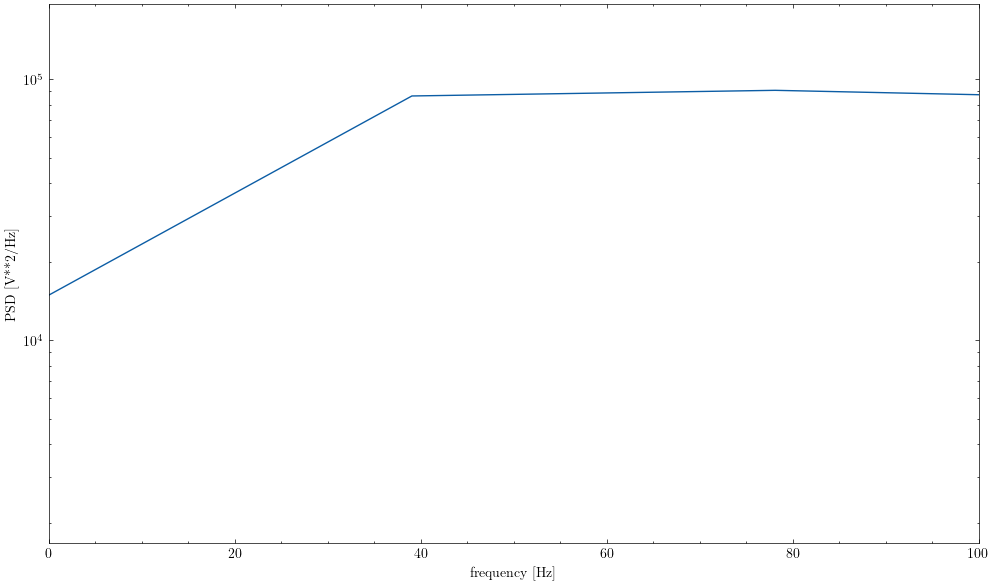

In [ ]:
spikes_E = hmm_network_3.spikes_E
spike_events = spikes_E.get("events")

dt = 0.1
sampling_frequency = 1 / dt * 1000  # Hz

plot_power_spectrum_density(spike_events, sampling_frequency)